
APPLYING TUNA MEDIUM METHODOLOGY
🔬 Parameters: 30% threshold, 2-min windows, 25% penalty, 50/50 blending

📊 Processing IOWait with TUNA Medium:
  🔍 CPU STRESS:
    ✅ TUNA-Medium: 40 unstable periods, 26.2% noise reduction
  🔍 BASELINE:
    ✅ TUNA-Medium: 47 unstable periods, 22.4% noise reduction

📊 Processing IRQ with TUNA Medium:
  🔍 CPU STRESS:
    ✅ TUNA-Medium: 6 unstable periods, 16.8% noise reduction
  🔍 BASELINE:
    ✅ TUNA-Medium: 9 unstable periods, 39.8% noise reduction

📊 Processing System with TUNA Medium:
  🔍 CPU STRESS:
    ✅ TUNA-Medium: 3 unstable periods, 27.5% noise reduction
  🔍 BASELINE:
    ✅ TUNA-Medium: 11 unstable periods, 27.2% noise reduction

📊 Processing User with TUNA Medium:
  🔍 CPU STRESS:
    ✅ TUNA-Medium: 3 unstable periods, 19.3% noise reduction
  🔍 BASELINE:
    ✅ TUNA-Medium: 1 unstable periods, 13.4% noise reduction

📊 Processing Utilization with TUNA Medium:
  🔍 CPU STRESS:
    ✅ TUNA-Medium: 3 unstable periods, 19.8% noise reduction
  🔍 BASELIN

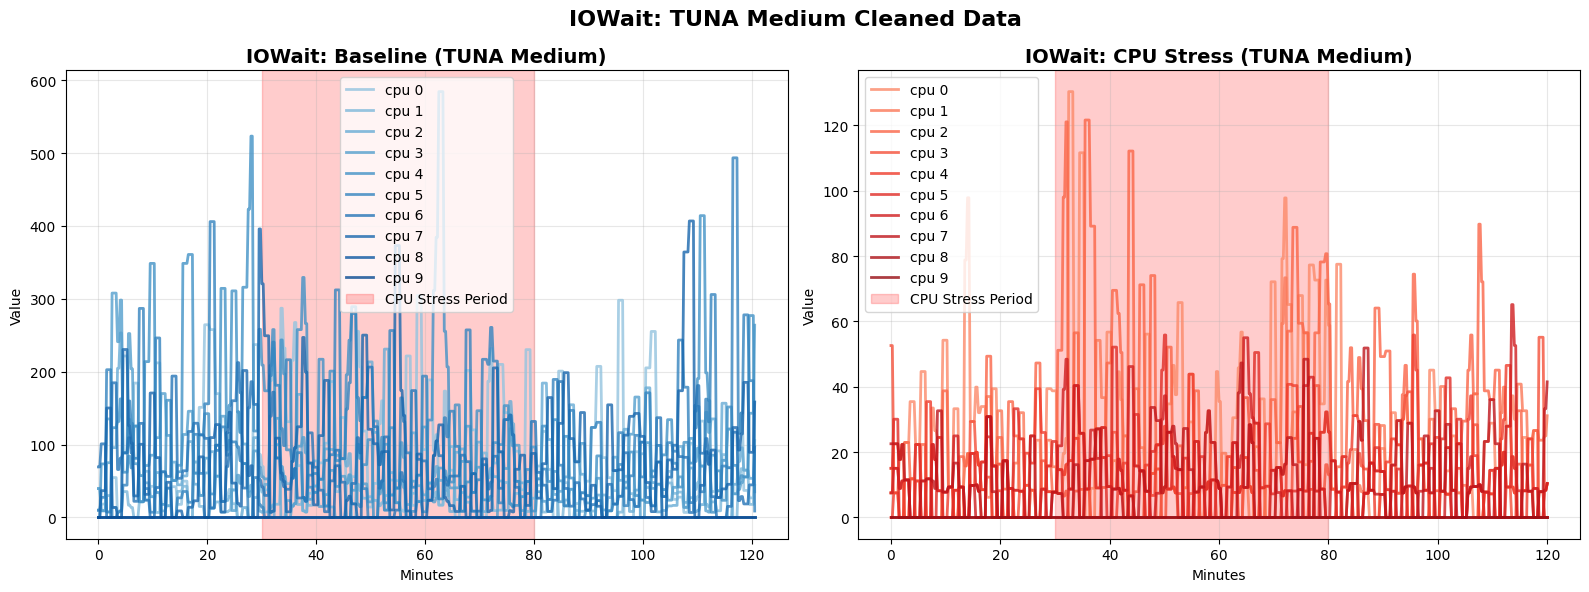

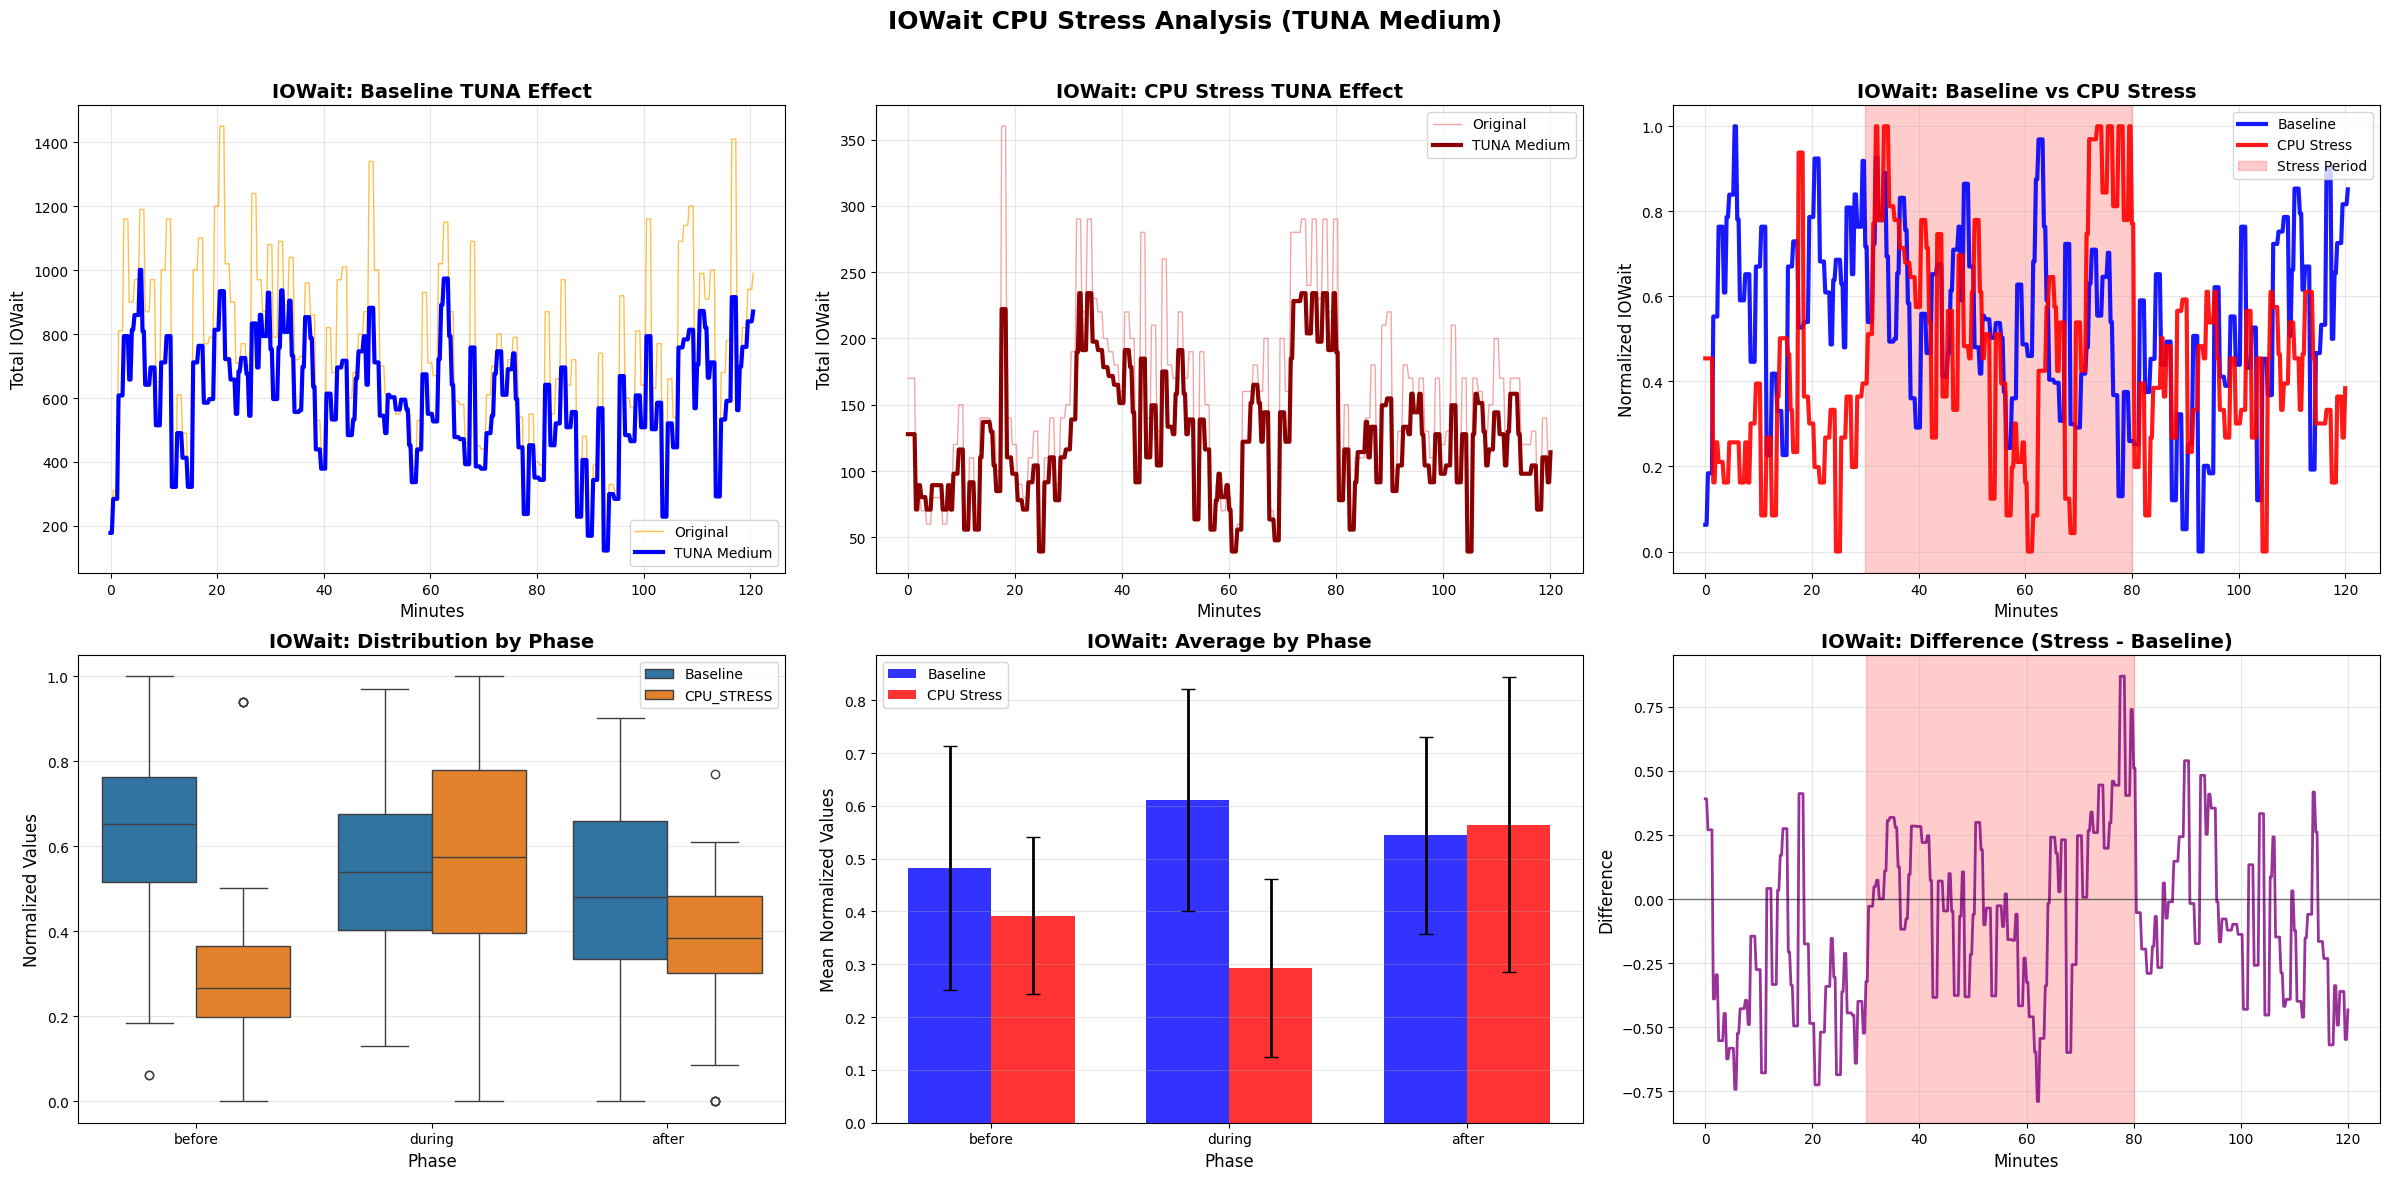


IOWAIT - TUNA MEDIUM ANALYSIS RESULTS

🔧 TUNA CLEANING SUMMARY:
  CPU STRESS: 40 unstable periods, 26.2% noise reduction
  BASELINE:   47 unstable periods, 22.4% noise reduction
  METHOD:     TUNA-Medium

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4825  0.2305  0.0000  0.9027
before  0.6111  0.2096  0.0628  1.0000
during  0.5440  0.1861  0.1300  0.9691

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3921  0.1481  0.0000  0.7711
before  0.2936  0.1686  0.0001  0.9383
during  0.5645  0.2790  0.0001  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 12.93, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -0.86, p=  0.3879 (❌ NOT SIGNIFICANT)
  AFTER   : t=  4.18, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -51.96% (↘️ DECREASE)
  DURING  :   +3.76% (↗️ INCREASE)
  AFTER   :  -18.74% (↘️ DECREASE)

🔄 Analyzing 

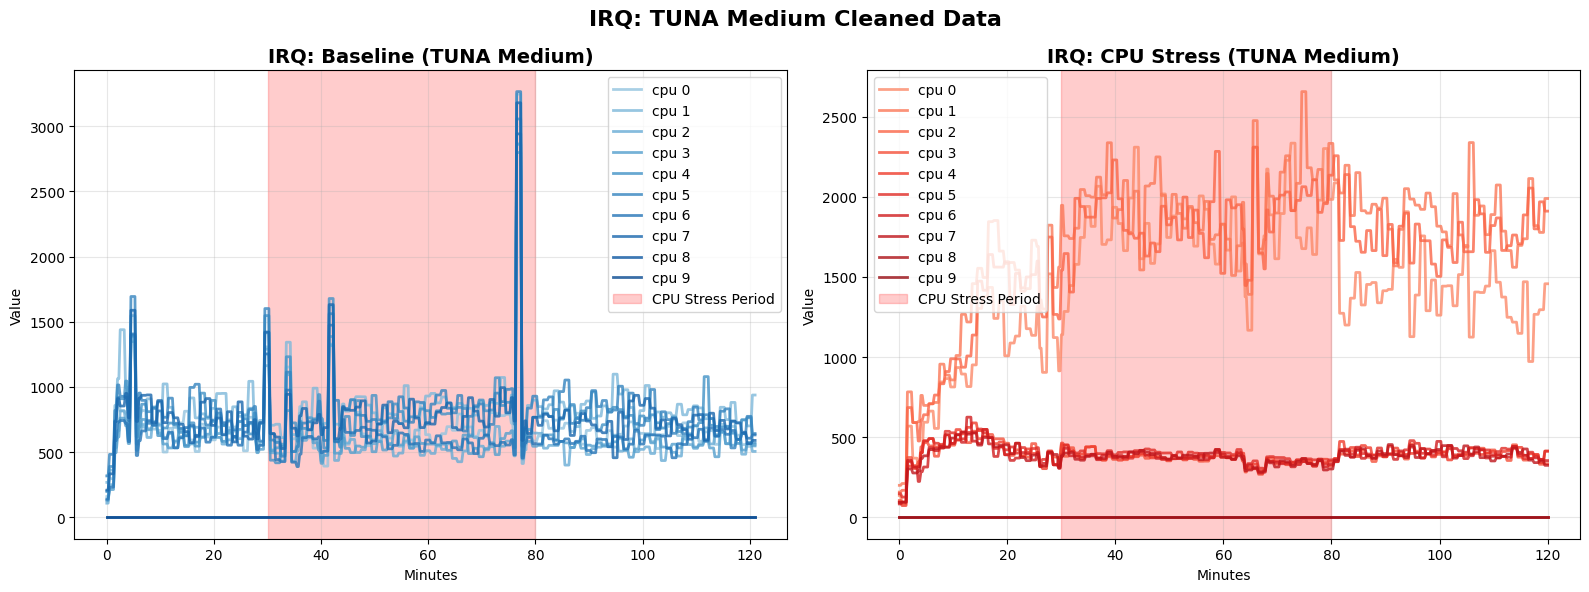

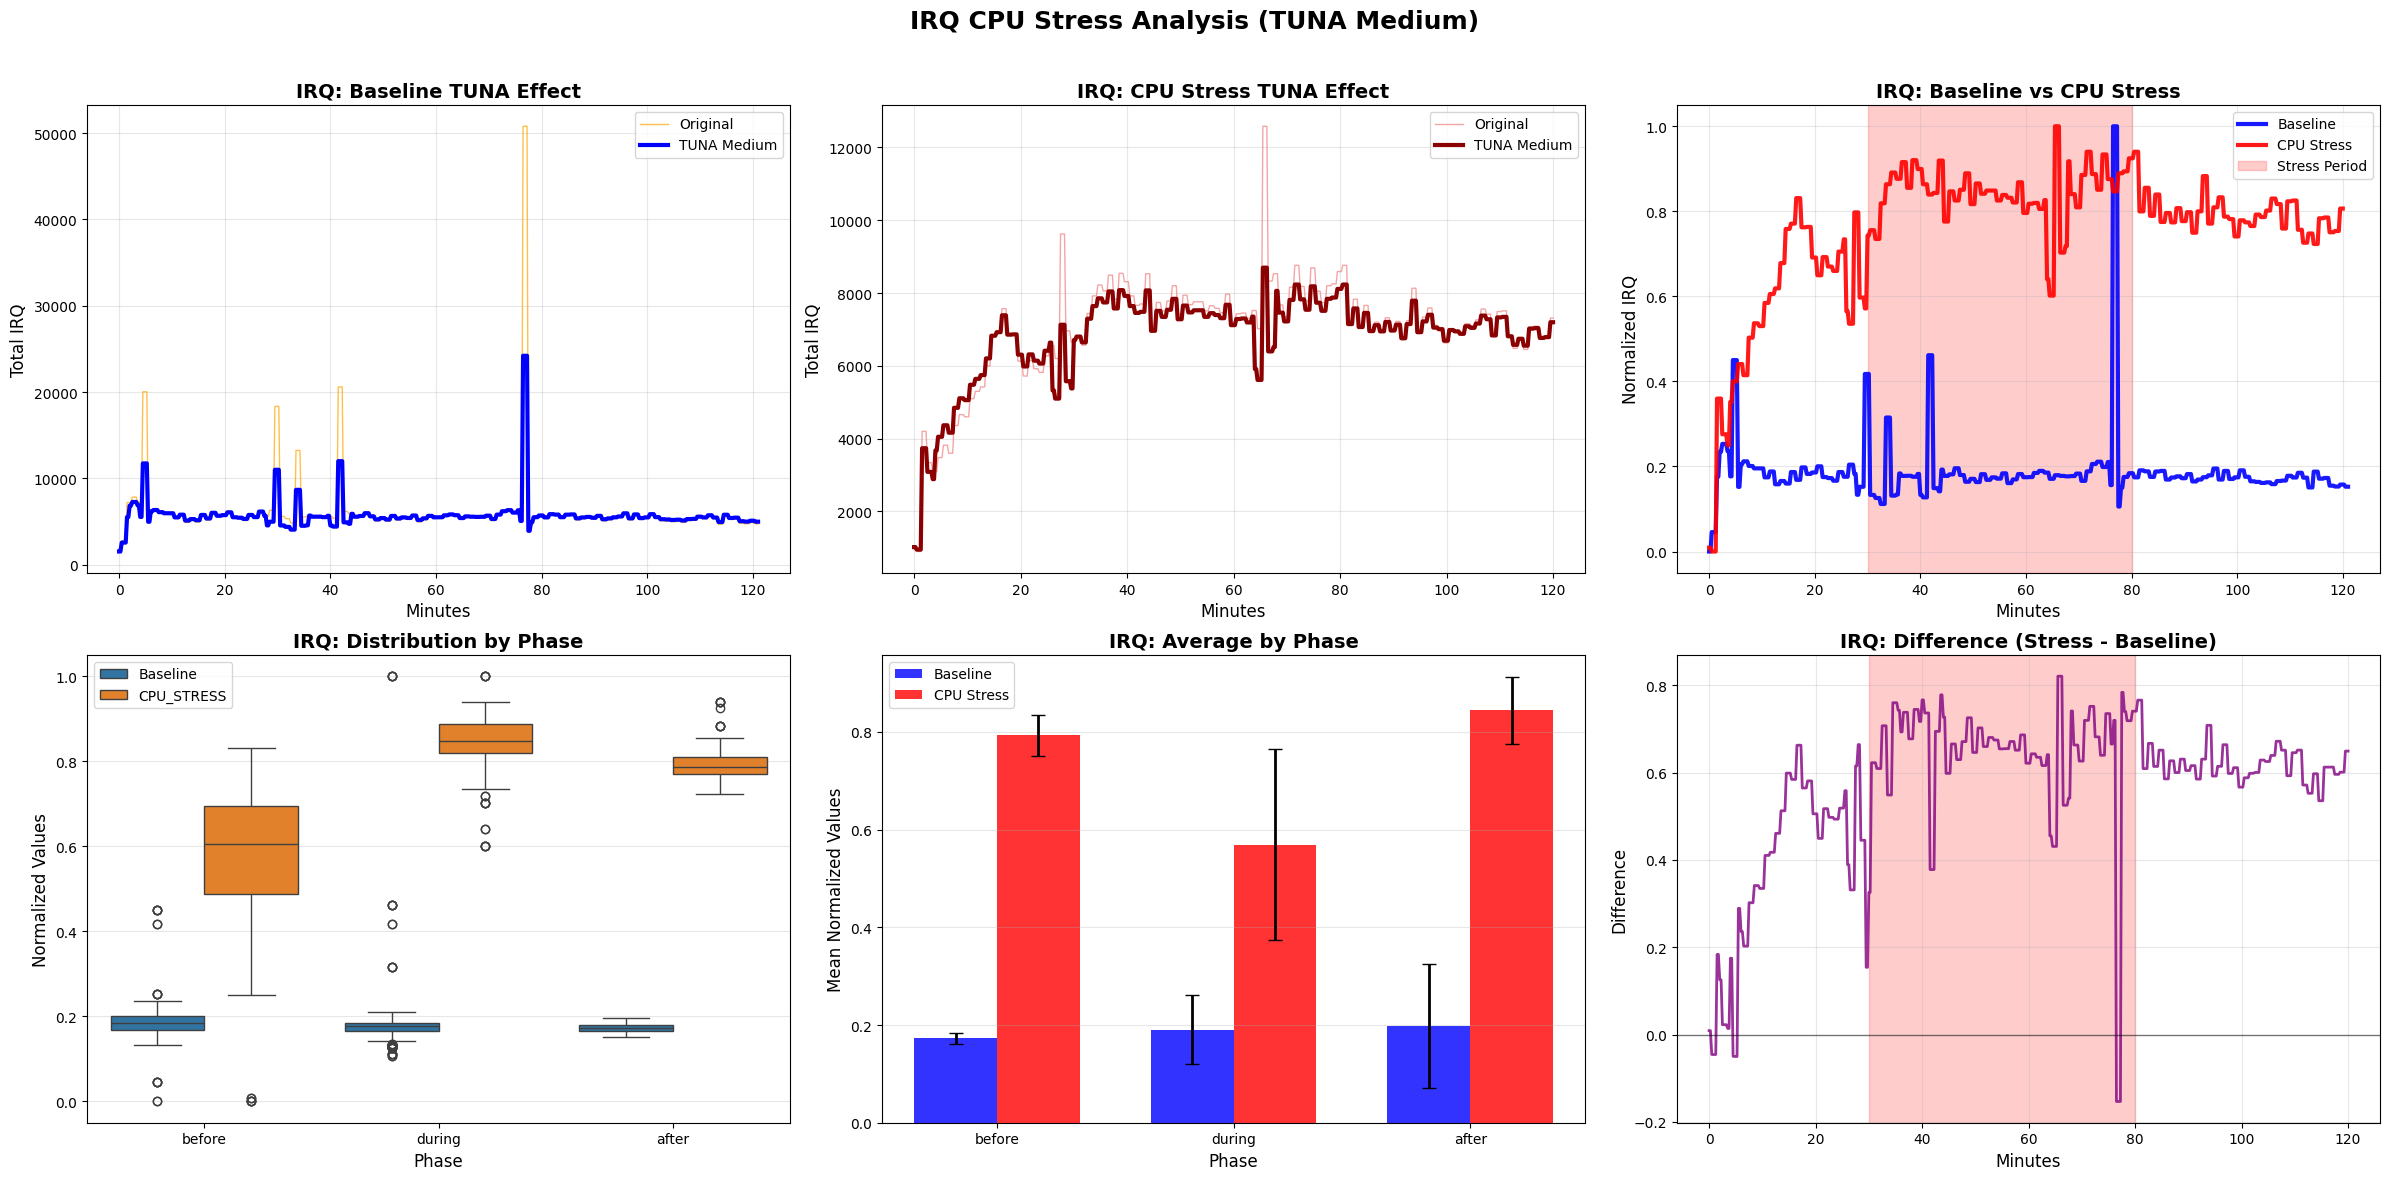


IRQ - TUNA MEDIUM ANALYSIS RESULTS

🔧 TUNA CLEANING SUMMARY:
  CPU STRESS: 6 unstable periods, 16.8% noise reduction
  BASELINE:   9 unstable periods, 39.8% noise reduction
  METHOD:     TUNA-Medium

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1731  0.0115  0.1506  0.1951
before  0.1904  0.0706  0.0000  0.4502
during  0.1985  0.1271  0.1058  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7931  0.0424  0.7232  0.9401
before  0.5691  0.1956  0.0000  0.8310
during  0.8439  0.0680  0.6018  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=-19.95, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-63.46, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=-180.82, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  : +198.95% (↗️ INCREASE)
  DURING  : +325.09% (↗️ INCREASE)
  AFTER   : +358.15% (↗️ INCREASE)

🔄 Analyzing System..

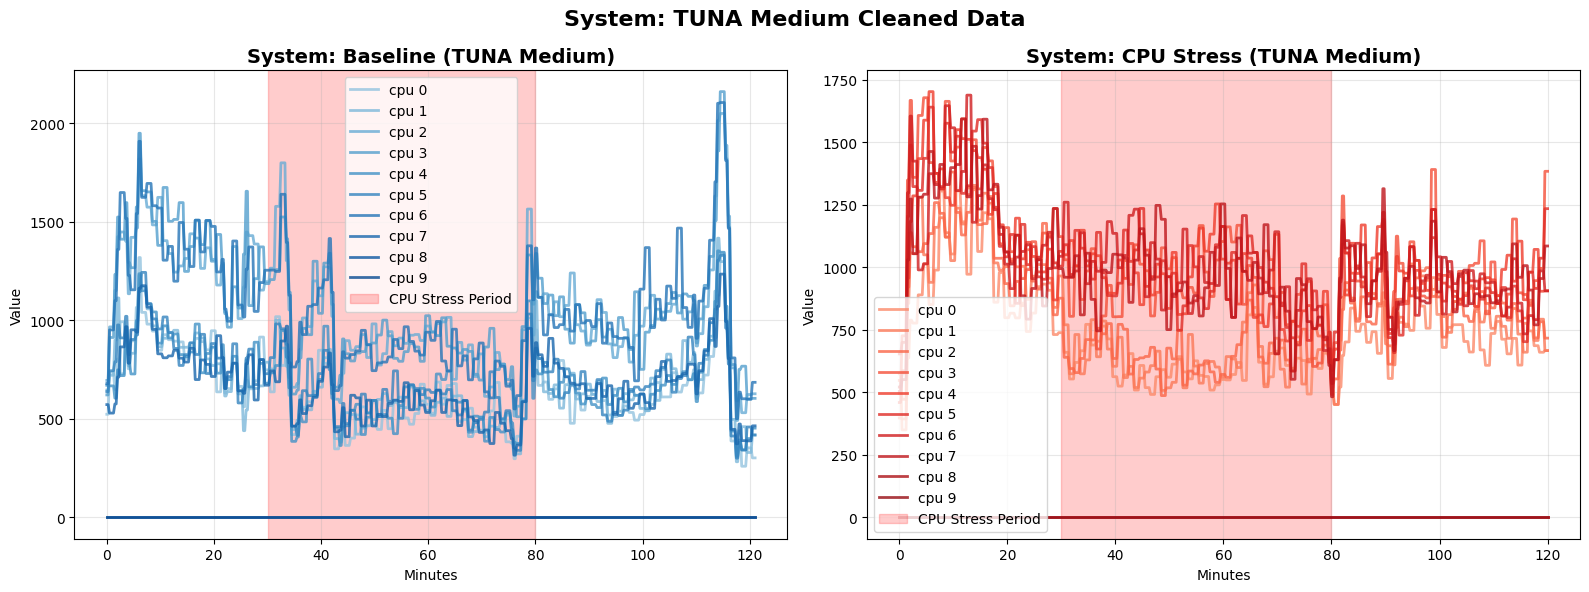

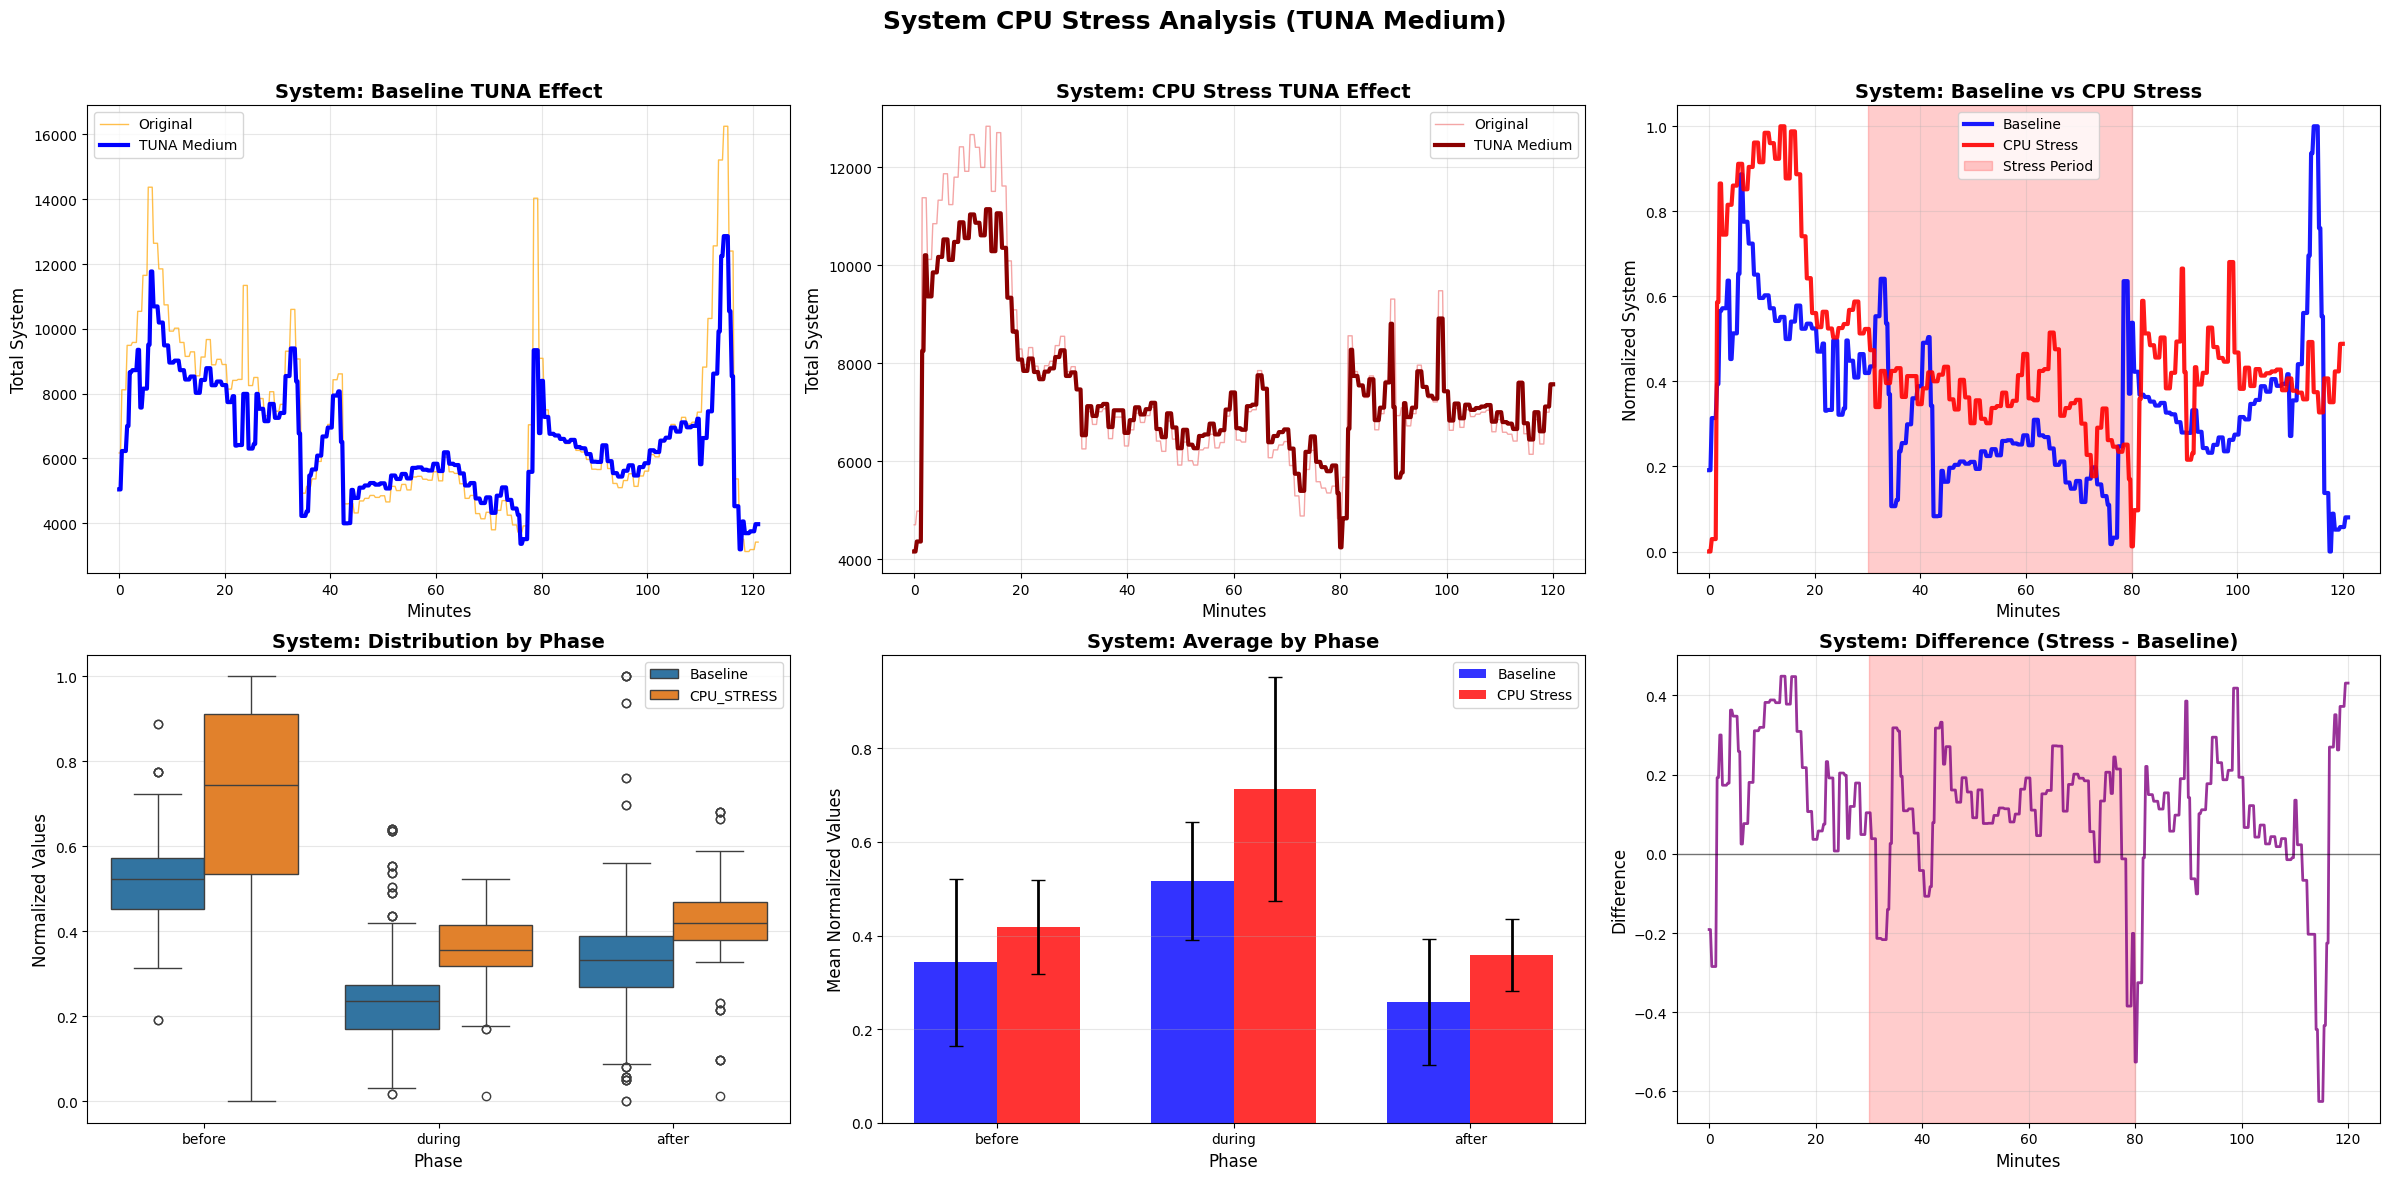


SYSTEM - TUNA MEDIUM ANALYSIS RESULTS

🔧 TUNA CLEANING SUMMARY:
  CPU STRESS: 3 unstable periods, 27.5% noise reduction
  BASELINE:   11 unstable periods, 27.2% noise reduction
  METHOD:     TUNA-Medium

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3424  0.1784  0.0000  1.0000
before  0.5162  0.1266  0.1912  0.8871
during  0.2575  0.1347  0.0174  0.6413

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4187  0.1009  0.0122  0.6807
before  0.7132  0.2386  0.0000  1.0000
during  0.3589  0.0769  0.0122  0.5234

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -7.99, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -9.27, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= -4.72, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  +38.16% (↗️ INCREASE)
  DURING  :  +39.39% (↗️ INCREASE)
  AFTER   :  +22.28% (↗️ INCREASE)

🔄 Analyzing User.

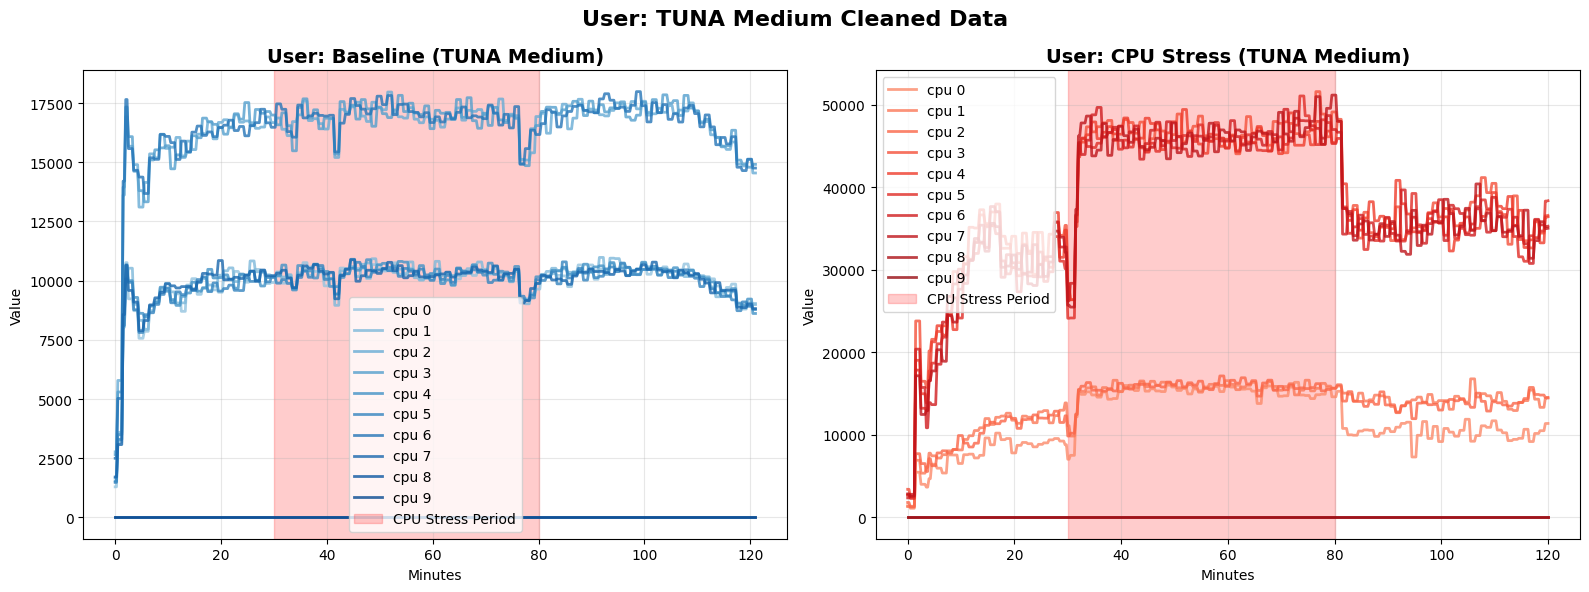

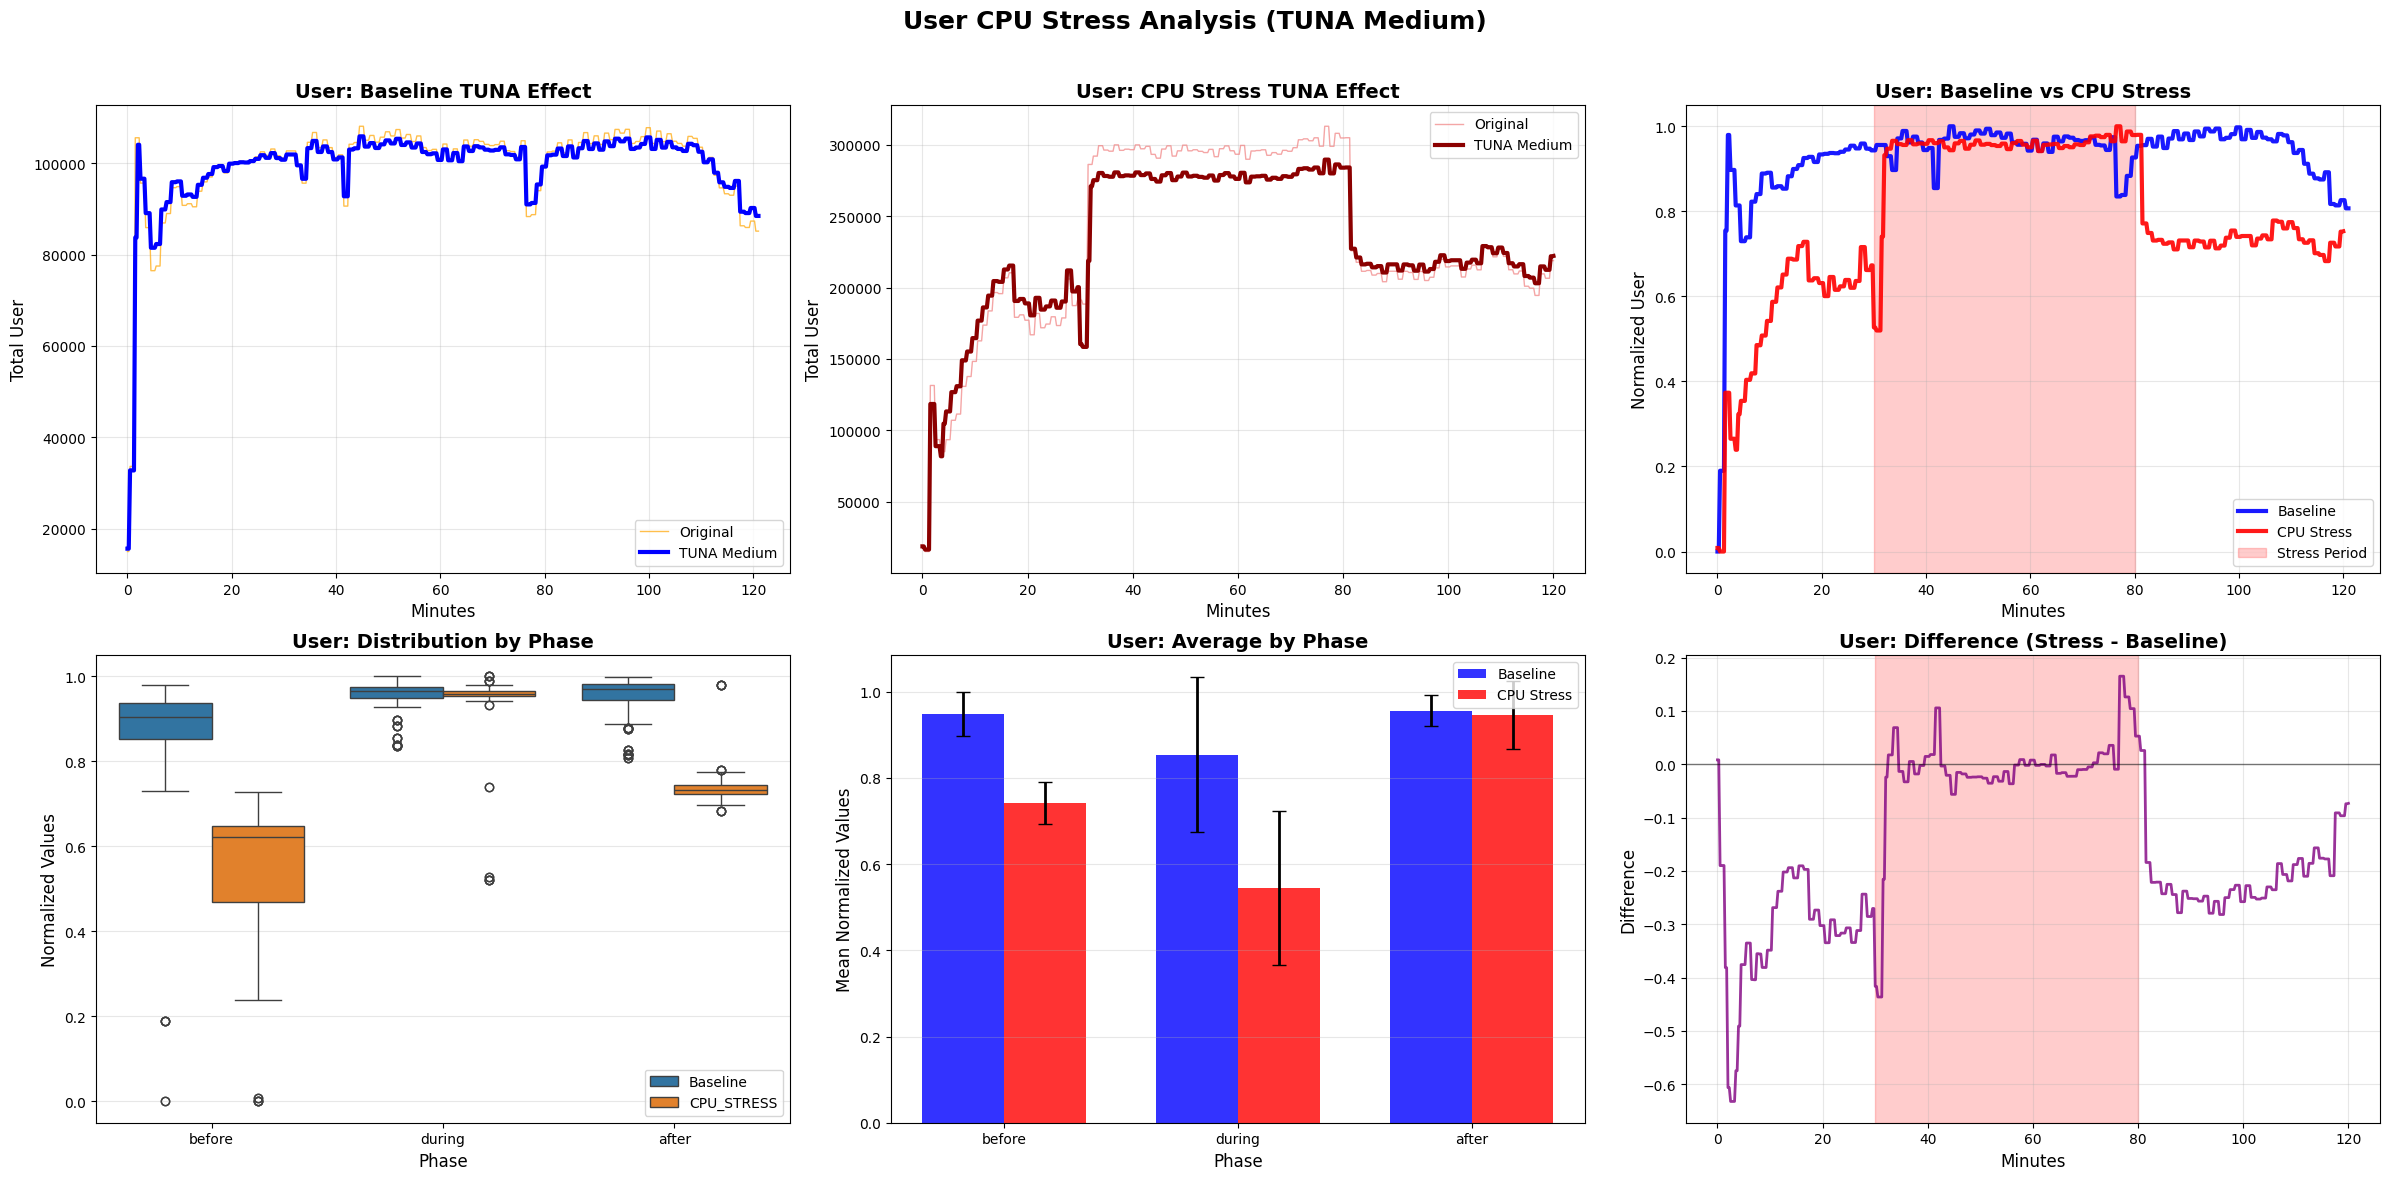


USER - TUNA MEDIUM ANALYSIS RESULTS

🔧 TUNA CLEANING SUMMARY:
  CPU STRESS: 3 unstable periods, 19.3% noise reduction
  BASELINE:   1 unstable periods, 13.4% noise reduction
  METHOD:     TUNA-Medium

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9480  0.0520  0.8070  0.9975
before  0.8539  0.1796  0.0000  0.9795
during  0.9558  0.0358  0.8349  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7417  0.0476  0.6829  0.9799
before  0.5441  0.1781  0.0000  0.7283
during  0.9453  0.0784  0.5198  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 13.41, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  1.72, p=  0.0859 (❌ NOT SIGNIFICANT)
  AFTER   : t= 37.23, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -36.28% (↘️ DECREASE)
  DURING  :   -1.09% (↘️ DECREASE)
  AFTER   :  -21.76% (↘️ DECREASE)

🔄 Analyzing Util

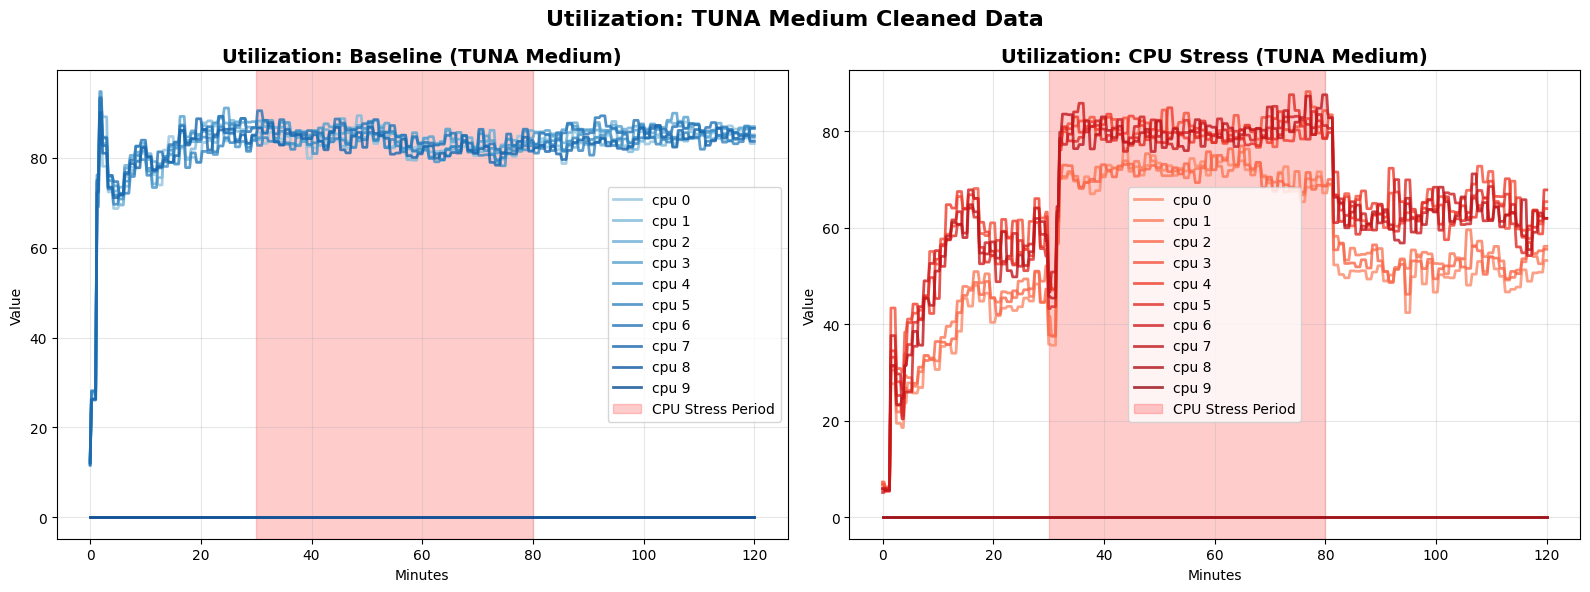

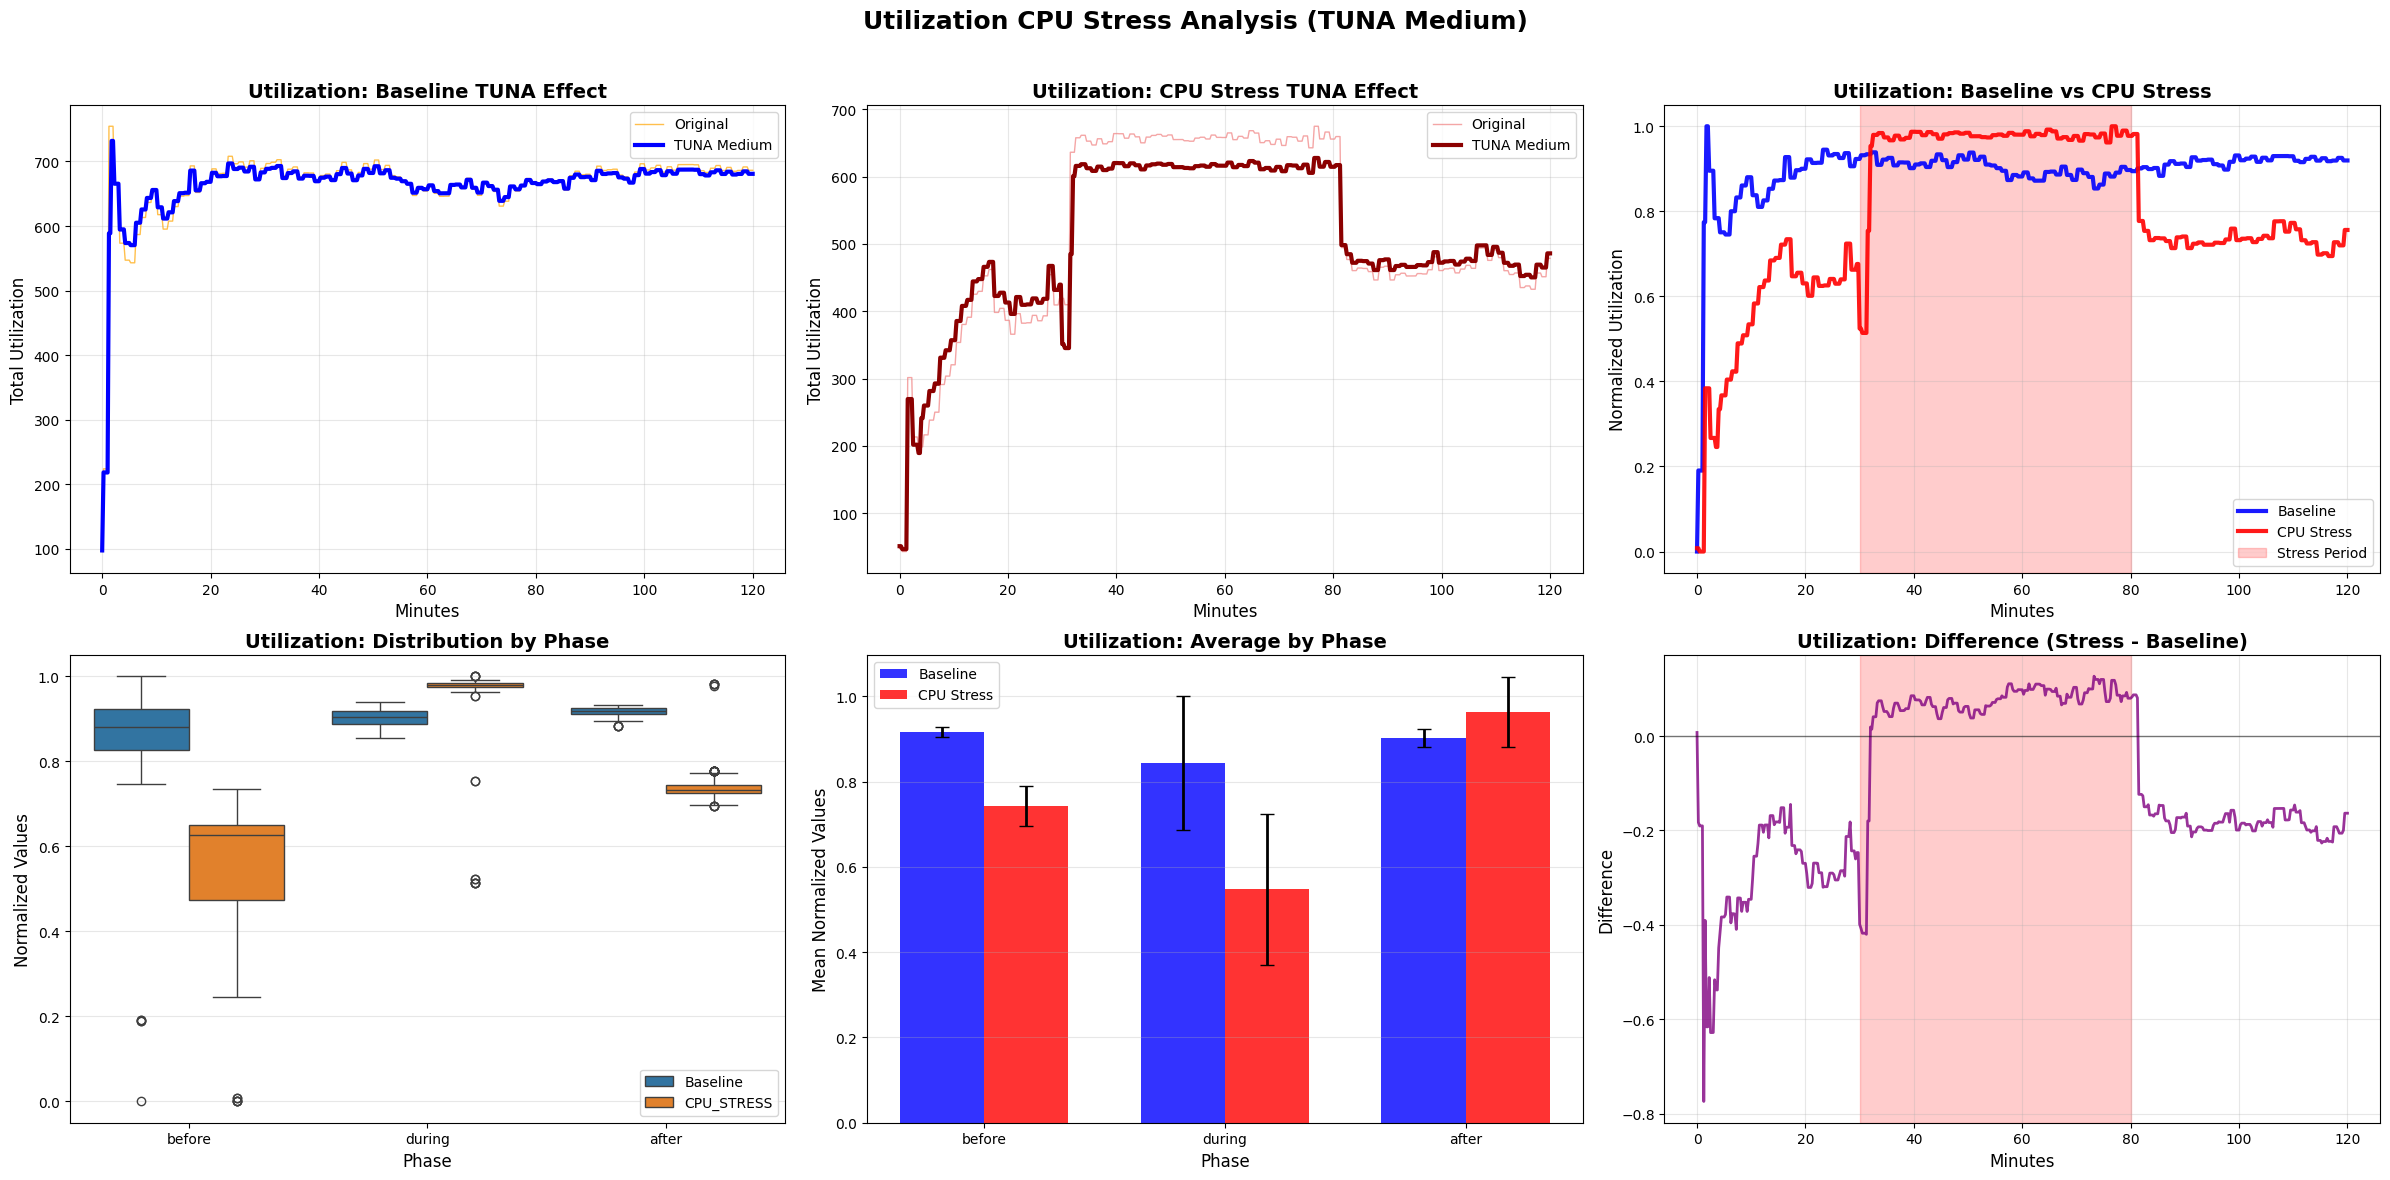


UTILIZATION - TUNA MEDIUM ANALYSIS RESULTS

🔧 TUNA CLEANING SUMMARY:
  CPU STRESS: 3 unstable periods, 19.8% noise reduction
  BASELINE:   1 unstable periods, 12.2% noise reduction
  METHOD:     TUNA-Medium

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9165  0.0112  0.8834  0.9314
before  0.8441  0.1568  0.0000  1.0000
during  0.9024  0.0206  0.8537  0.9387

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7428  0.0472  0.6947  0.9818
before  0.5470  0.1779  0.0000  0.7344
during  0.9630  0.0818  0.5140  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 13.73, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-10.18, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= 45.33, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -35.20% (↘️ DECREASE)
  DURING  :   +6.72% (↗️ INCREASE)
  AFTER   :  -18.95% (↘️ DECREASE)

COMPREHENSIVE

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all datasets
df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source labels
df_iowait["source"] = "CPU STRESS"
df_cpu_irq["source"] = "CPU STRESS"
df_system_msec["source"] = "CPU STRESS"
df_user_msec["source"] = "CPU STRESS"
df_cpu_util["source"] = "CPU STRESS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert to datetime
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

# Convert timeline to minutes 
all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY 
original_datasets = {
    'IOWait': {'cpu_stress': df_iowait, 'baseline': df_baseline_iowait},
    'IRQ': {'cpu_stress': df_cpu_irq, 'baseline': df_baseline_irq},
    'System': {'cpu_stress': df_system_msec, 'baseline': df_baseline_system_msec},
    'User': {'cpu_stress': df_user_msec, 'baseline': df_baseline_user_msec},
    'Utilization': {'cpu_stress': df_cpu_util, 'baseline': df_baseline_util_per}
}

# TUNA MEDIUM IMPLEMENTATION
def apply_tuna_cleaning_paper_always_medium(df):
    """
    - 30% relative range threshold 
    - 2-minute windows 
    - 25% penalty (medium - gentler than paper's 50%)
    - 50% original + 50% corrected blending
    """
    df_result = df.copy()
    
    cpu_columns = [col for col in df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9']]
    outlier_stats = {}
    
    if len(cpu_columns) == 0:
        return df_result, outlier_stats
    
    df_result['Total_CPU'] = df_result[cpu_columns].sum(axis=1)
    
    # STEP 1: Outlier detection and correction
    outliers_detected = 0
    
    if 'Time' in df.columns:
        df_result['Time'] = pd.to_datetime(df_result['Time'])
        df_result.set_index('Time', inplace=True)
        
        grouped = df_result.groupby(pd.Grouper(freq='2min'))
        
        for name, group in grouped:
            if len(group) < 2:
                continue
                
            values = group['Total_CPU'].values
            if len(values) > 1 and np.mean(values) > 0:
                relative_range = (np.max(values) - np.min(values)) / np.mean(values) #relative range formula
                
                if relative_range > 0.30:
                    correction_factor = 0.75  # 25% penalty
                    df_result.loc[group.index, 'Total_CPU'] *= correction_factor
                    for col in cpu_columns:
                        df_result.loc[group.index, col] *= correction_factor
                    outliers_detected += 1
        
        df_result.reset_index(inplace=True)
    
    # STEP 2: Noise modeling
    noise_reduction = 0
    
    if len(df_result) >= 20:
        try:
            feature_df = df_result.copy()
            feature_df['CPU_Mean'] = feature_df[cpu_columns].mean(axis=1)
            feature_df['CPU_Std'] = feature_df[cpu_columns].std(axis=1)
            feature_df['CPU_Max'] = feature_df[cpu_columns].max(axis=1)
            feature_df['CPU_Min'] = feature_df[cpu_columns].min(axis=1)
            feature_df['CPU_Range'] = feature_df['CPU_Max'] - feature_df['CPU_Min']
            
            if 'Time' in df.columns:
                feature_df['Hour'] = pd.to_datetime(feature_df['Time']).dt.hour
                feature_df['Minute'] = pd.to_datetime(feature_df['Time']).dt.minute
                feature_columns = cpu_columns + ['Hour', 'Minute', 'CPU_Mean', 'CPU_Std', 'CPU_Max', 'CPU_Min', 'CPU_Range']
            else:
                feature_columns = cpu_columns + ['CPU_Mean', 'CPU_Std', 'CPU_Max', 'CPU_Min', 'CPU_Range']
            
            target_mean = feature_df['Total_CPU'].mean()
            if target_mean > 0:
                feature_df['target'] = (feature_df['Total_CPU'] / target_mean) - 1
                
                clean_data = feature_df[feature_columns + ['target']].dropna()
                
                if len(clean_data) >= 10:
                    X = clean_data[feature_columns]
                    y = clean_data['target']
                    
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(X)
                    
                    model = RandomForestRegressor(
                        n_estimators=100,
                        random_state=42,
                        n_jobs=-1
                    )
                    model.fit(X_scaled, y)
                    
                    feature_matrix = feature_df[feature_columns].fillna(method='ffill').fillna(method='bfill').fillna(0)
                    X_pred_scaled = scaler.transform(feature_matrix)
                    predicted_error = model.predict(X_pred_scaled)
                    
                    original_std = df_result['Total_CPU'].std()
                    corrected_values = df_result['Total_CPU'] / (predicted_error * 0.5 + 1)
                    
                    # Blend 50% original + 50% corrected
                    df_result['Total_CPU'] = 0.5 * df_result['Total_CPU'] + 0.5 * corrected_values
                    
                    cleaned_std = df_result['Total_CPU'].std()
                    noise_reduction = ((original_std - cleaned_std) / original_std) * 100
                    
                    total_original = df_result[cpu_columns].sum(axis=1)
                    adjustment_ratio = df_result['Total_CPU'] / (total_original + 0.001)
                    for col in cpu_columns:
                        df_result[col] = df_result[col] * adjustment_ratio
        
        except Exception as e:
            print(f"    ⚠️  Noise modeling failed: {e}")
    
    outlier_stats['_summary'] = {
        'total_outliers': outliers_detected,
        'method': 'TUNA-Medium',
        'relative_threshold': 0.30,
        'time_window': '2min',
        'correction_penalty': 0.25,
        'noise_blending': '50% original + 50% corrected',
        'always_applied': True,
        'noise_reduction': noise_reduction
    }
    
    return df_result, outlier_stats


# APPLY TUNA CLEANING
datasets_clean = {}
all_outlier_stats = {}

print(f"\n{'='*80}")
print("APPLYING TUNA MEDIUM METHODOLOGY")
print(f"{'='*80}")
print("🔬 Parameters: 30% threshold, 2-min windows, 25% penalty, 50/50 blending")
print(f"{'='*80}")

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name} with TUNA Medium:")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        
        df_clean, stats = apply_tuna_cleaning_paper_always_medium(df)
        
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats
        
        total_outliers = stats['_summary']['total_outliers']
        noise_reduction = stats['_summary']['noise_reduction']
        method = stats['_summary']['method']
        print(f"    ✅ {method}: {total_outliers} unstable periods, {noise_reduction:.1f}% noise reduction")

# NORMALIZATION FUNCTION
def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# ADD PHASE COLUMN
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# PLOT INDIVIDUAL CPU COLUMNS
def plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu')]
    
    if len(cpu_cols) == 0:
        print(f"No CPU columns found in {dataset_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Baseline Data
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax1.plot(baseline_df['Minutes'], baseline_df[cpu_col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax1.set_title(f'{dataset_name}: Baseline (TUNA Medium)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # CPU Stress Data
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax2.plot(cpu_stress_df['Minutes'], cpu_stress_df[cpu_col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax2.set_title(f'{dataset_name}: CPU Stress (TUNA Medium)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.suptitle(f'{dataset_name}: TUNA Medium Cleaned Data', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# MAIN ANALYSIS FUNCTION
def analyze_and_plot_dataset_wide(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu')]
    
    print(f"\n📊 Plotting TUNA Medium cleaned data for {dataset_name}...")
    plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes)
    
    cpu_stress_norm = normalize_df(cpu_stress_df, cpu_cols)
    baseline_norm = normalize_df(baseline_df, cpu_cols)
    
    # Use TUNA-cleaned Total_CPU if available
    if 'Total_CPU' in cpu_stress_df.columns:
        cpu_stress_df['Total'] = cpu_stress_df['Total_CPU']
        baseline_df['Total'] = baseline_df['Total_CPU']
    else:
        cpu_stress_df['Total'] = cpu_stress_df[cpu_cols].sum(axis=1)
        baseline_df['Total'] = baseline_df[cpu_cols].sum(axis=1)
    
    # Normalize totals
    cpu_stress_norm['Total'] = (cpu_stress_df['Total'] - cpu_stress_df['Total'].min()) / (cpu_stress_df['Total'].max() - cpu_stress_df['Total'].min())
    baseline_norm['Total'] = (baseline_df['Total'] - baseline_df['Total'].min()) / (baseline_df['Total'].max() - baseline_df['Total'].min())
    
    # Add phase information
    cpu_stress_norm = add_phase_column(cpu_stress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    stats_cpu_stress = cpu_stress_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm['Total'],
        'CPU_STRESS': cpu_stress_norm['Total'],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpu_stress_norm['Total'] - baseline_norm['Total']
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpu_stress_mean = stats_cpu_stress.loc[phase, 'mean']
        impact[phase] = ((cpu_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # COMPARISON PLOTS
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline TUNA effect
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[cpu_cols].sum(axis=1), 
             label='Original', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df['Total'], 
             label='TUNA Medium', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline TUNA Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS TUNA effect
    plt.subplot(2, 3, 2)
    original_cpu_stress = original_datasets[dataset_name]['cpu_stress']
    
    plt.plot(original_cpu_stress['Minutes'], original_cpu_stress[cpu_cols].sum(axis=1), 
             label='Original', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpu_stress_df['Minutes'], cpu_stress_df['Total'], 
             label='TUNA Medium', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: CPU Stress TUNA Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm['Total'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpu_stress_norm['Minutes'], cpu_stress_norm['Total'], 
             label='CPU Stress', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress Period")
    plt.title(f"{dataset_name}: Baseline vs CPU Stress", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {dataset_name}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpu_stress['mean'], width, label='CPU Stress', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpu_stress['mean'], yerr=stats_cpu_stress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: Difference (Stress - Baseline)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} CPU Stress Analysis (TUNA Medium)', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    # Print results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - TUNA MEDIUM ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    cpu_stress_stats = all_outlier_stats[dataset_name]['cpu_stress']['_summary']
    baseline_stats = all_outlier_stats[dataset_name]['baseline']['_summary']
    
    print(f"\n🔧 TUNA CLEANING SUMMARY:")
    print(f"  CPU STRESS: {cpu_stress_stats['total_outliers']} unstable periods, {cpu_stress_stats['noise_reduction']:.1f}% noise reduction")
    print(f"  BASELINE:   {baseline_stats['total_outliers']} unstable periods, {baseline_stats['noise_reduction']:.1f}% noise reduction")
    print(f"  METHOD:     {cpu_stress_stats['method']}")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpu_stress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpu_stress': stats_cpu_stress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'cpu_columns': cpu_cols
    }

# RUN ANALYSIS
print(f"\n{'='*80}")
print("COMPREHENSIVE CPU STRESS ANALYSIS - TUNA MEDIUM")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    cpu_stress_clean = datasets_clean[dataset_name]['cpu_stress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_dataset_wide(
        dataset_name, 
        cpu_stress_clean, 
        baseline_clean, 
        delay, 
        duration
    )

# FINAL SUMMARY
print(f"\n{'='*100}")
print("COMPREHENSIVE CPU STRESS IMPACT SUMMARY - TUNA MEDIUM")
print(f"{'='*100}")

summary_table = []
for dataset_name, results in analysis_results.items():
    if results:
        for phase in ['before', 'during', 'after']:
            cpu_stress_stats = all_outlier_stats[dataset_name]['cpu_stress']['_summary']
            baseline_stats = all_outlier_stats[dataset_name]['baseline']['_summary']
            
            summary_table.append({
                'CPU_Metric': dataset_name,
                'Phase': phase,
                'Impact (%)': f"{results['impact'][phase]:+.1f}%",
                'P-Value': f"{results['t_tests'][phase]['p']:.4f}",
                'Significant': 'YES' if results['t_tests'][phase]['p'] < 0.05 else 'NO',
                'T-Statistic': f"{results['t_tests'][phase]['t']:.2f}",
                'CPU_Columns': len(results['cpu_columns']),
                'TUNA_Outliers': f"{cpu_stress_stats['total_outliers']}/{baseline_stats['total_outliers']}",
                'Noise_Reduction': f"{cpu_stress_stats['noise_reduction']:.1f}%"
            })

if summary_table:
    summary_df = pd.DataFrame(summary_table)
    print(summary_df.to_string(index=False, col_space=12))

print(f"\n{'='*80}")
print("TUNA MEDIUM ANALYSIS COMPLETE!")
print(f"{'='*80}")